## View detection

### 1. Imports

In [59]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from tqdm import tqdm

from helpers.view_detection import get_view_mask


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


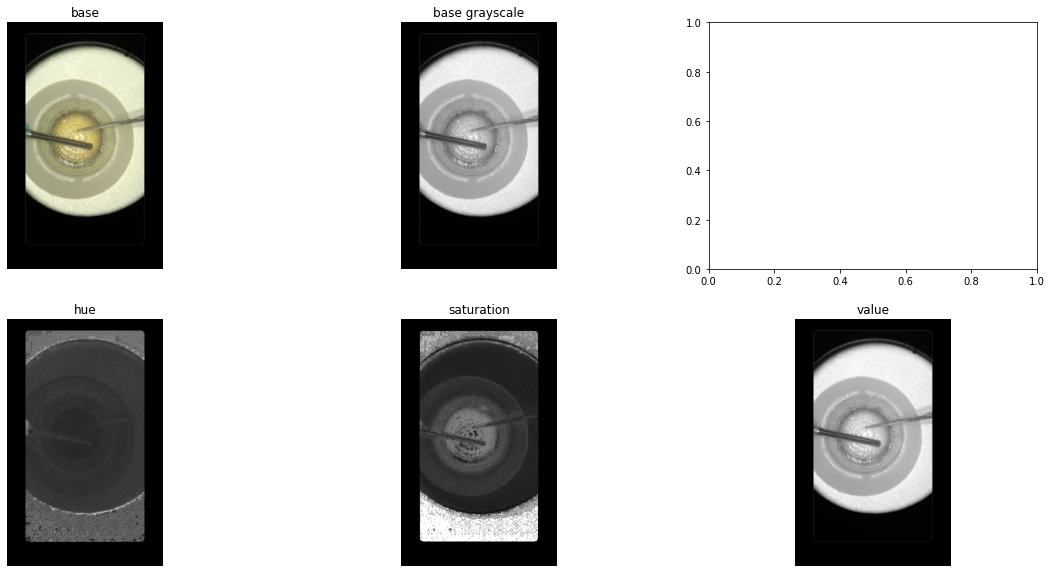

size: 312x496


In [60]:
scale = 0.33

base = cv2.imread('data/artificial/bioniko_rhexis_base4.png', cv2.IMREAD_COLOR)
base = cv2.resize(base, (0, 0), fx=scale, fy=scale)

base_rgb = cv2.cvtColor(base, cv2.COLOR_BGR2RGB)
base_gray = cv2.cvtColor(base, cv2.COLOR_BGR2GRAY)
base_hsv = cv2.cvtColor(base, cv2.COLOR_BGR2HSV)

base_hue = base_hsv[:, :, 0]
base_saturation = base_hsv[:, :, 1]
base_value = base_hsv[:, :, 2]

fig, ((plot1, plot2, _), (plot3, plot4, plot5)
      ) = plt.subplots(2, 3, figsize=(20, 10))
plot1.set_title('base')
plot1.imshow(base_rgb)
plot1.axis('off')

plot2.set_title('base grayscale')
plot2.imshow(base_gray, cmap=plt.cm.gray)
plot2.axis('off')

plot3.set_title('hue')
plot3.imshow(base_hue, cmap=plt.cm.gray)
plot3.axis('off')

plot4.set_title('saturation')
plot4.imshow(base_saturation, cmap=plt.cm.gray)
plot4.axis('off')

plot5.set_title('value')
plot5.imshow(base_value, cmap=plt.cm.gray)
plot5.axis('off')

plt.show()

print('size: %dx%d' % (base.shape[1], base.shape[0]))

### 2. Circle detection with inout validation (minimized)
For more info see `get_view_mask` method.

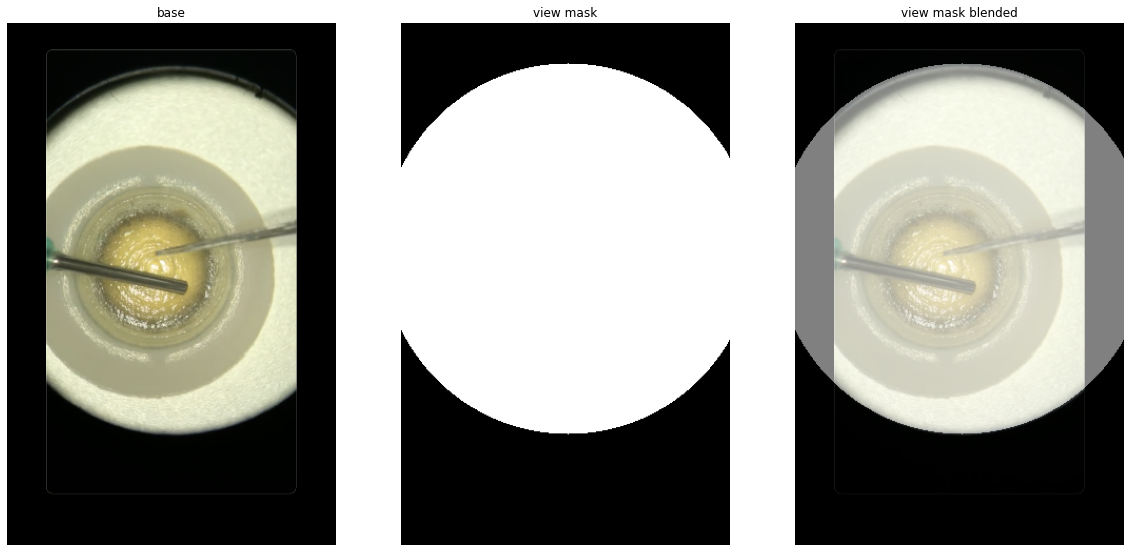

In [61]:
view_mask = get_view_mask(base_gray, radius_shrink=1.0)
view_blended = cv2.addWeighted(
    base_rgb,
    0.5,
    cv2.cvtColor(view_mask, cv2.COLOR_GRAY2RGB),
    0.5,
    0.0
)

fig, plots = plt.subplots(1, 3, figsize=(20, 10))
plots[0].set_title('base')
plots[0].imshow(base_rgb)
plots[0].axis('off')

plots[1].set_title('view mask')
plots[1].imshow(view_mask, cmap='gray')
plots[1].axis('off')

plots[2].set_title('view mask blended')
plots[2].imshow(view_blended)
plots[2].axis('off')

plt.show()

### 3. Validation of the results

[]

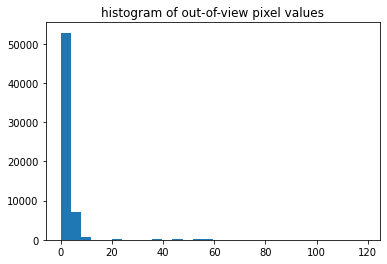

In [62]:
plt.title('histogram of out-of-view pixel values')
plt.hist(base_value[view_mask == 0], bins=30)
plt.plot()

### 4. Active contours

In [63]:
def detect_view_snake(value, return_verbose=False):
    padding = min(value.shape) // 10
    value_padded = cv2.copyMakeBorder(
        value,
        padding, padding, padding, padding,
        cv2.BORDER_CONSTANT, value=0)

    padding_init = padding // 2
    points_init_count = 300
    width_points_init_count = round(
        (value.shape[1] / sum(value.shape)) * points_init_count / 2)
    height_points_init_count = round(
        (value.shape[0] / sum(value.shape)) * points_init_count / 2)

    x = np.linspace(
        padding_init, value_padded.shape[1] - padding_init, width_points_init_count)
    y = np.linspace(
        padding_init, value_padded.shape[0] - padding_init, height_points_init_count)

    xs = np.concatenate((
        x,
        np.ones_like(y)*(value_padded.shape[1] - padding_init),
        np.flip(x),
        np.ones_like(y)*padding_init
    ))
    ys = np.concatenate((
        np.ones_like(x)*padding_init,
        y,
        np.ones_like(x)*(value_padded.shape[0] - padding_init),
        np.flip(y)
    ))
    init = np.array([ys, xs]).T
    snake = active_contour(gaussian(value_padded, 3, preserve_range=False),
                           init, alpha=0.001, beta=0.1, gamma=0.001)

    if return_verbose:
        return snake, init, value_padded
    else:
        return snake

(558, 374)


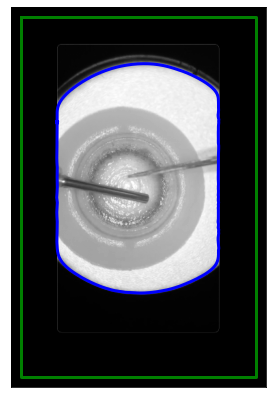

In [64]:
snake, init, base_value_padded = detect_view_snake(
    base_value, return_verbose=True)

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(base_value_padded, cmap='gray')
ax.plot(init[:, 1], init[:, 0], '-g', lw=3)
ax.plot(snake[:, 1], snake[:, 0], '-b', lw=3)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, base_value_padded.shape[1], base_value_padded.shape[0], 0])

print(base_value_padded.shape)
plt.show()

In [11]:
snake.shape

(300, 2)

In [20]:
ret, thresh = cv2.threshold(base_value, 127, 255, 0)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [49]:
contours[4]

array([[[125, 241]],

       [[127, 241]]], dtype=int32)

In [53]:
snake_contour = np.round(np.expand_dims(snake, axis=1)).astype(np.int32)
snake_contour[:,:,[1,0]] = snake_contour[:,:,[0,1]]
snake_contour.shape

(300, 1, 2)

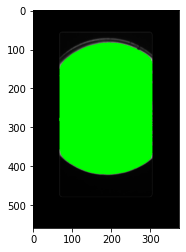

In [57]:
base_value_vis = cv2.cvtColor(base_value_padded, cv2.COLOR_GRAY2RGB)
# base_value_vis = cv2.drawContours(base_value_vis, contours, 10, (0,255,0))
base_value_vis = cv2.drawContours(base_value_vis, [snake_contour], 0, (0,255,0), thickness=-1)

plt.imshow(base_value_vis)

### 5. Testing multiple images

100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 45.33it/s]


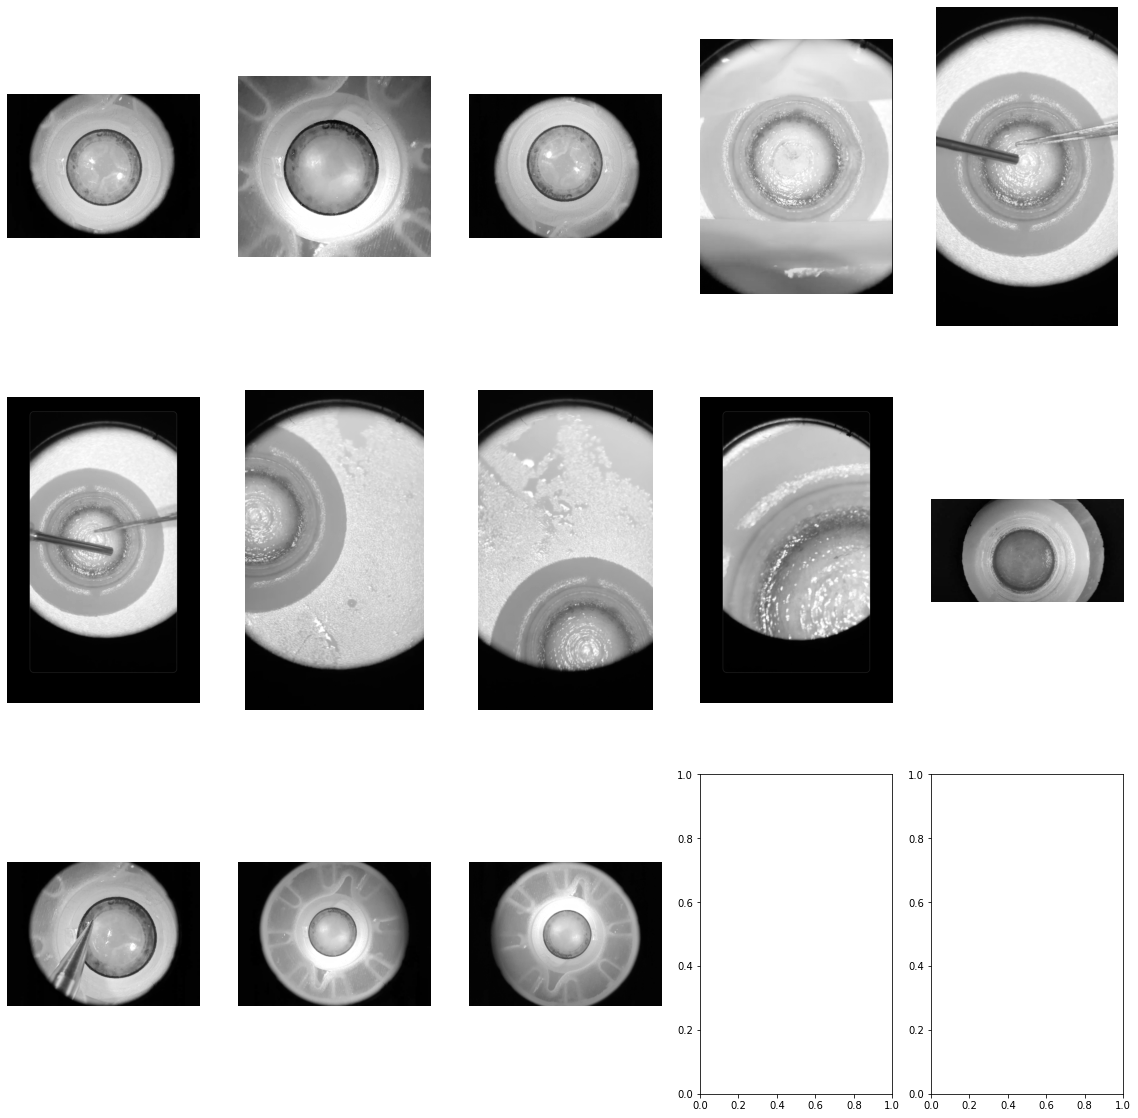

In [58]:
image_paths = [
    'data/artificial/base1.jpeg',
    'data/artificial/base2.jpeg',
    'data/artificial/base3.jpeg',
    'data/artificial/bioniko_rhexis_base2.png',
    'data/artificial/bioniko_rhexis_base3.png',
    'data/artificial/bioniko_rhexis_base4.png',
    'data/artificial/bioniko_rhexis_base5.png',
    'data/artificial/bioniko_rhexis_base6.png',
    'data/artificial/bioniko_rhexis_base7.png',
    'data/artificial/bioniko_rhexis_base8.png',
    'data/artificial/instrument.jpeg',
    'data/artificial/zoomed_out1.jpeg',
    'data/artificial/zoomed_out3.jpeg',
]
columns = 5
processing_width = 480

fig, plots = plt.subplots(
    np.ceil(len(image_paths)/columns).astype(np.int16), columns, figsize=(20, 20))
for i in tqdm(range(len(image_paths))):
    plot = plots[i // columns, i % columns]

    img = cv2.imread(image_paths[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img = img[:, :, 2]
    img = cv2.resize(img, (processing_width, round(
        processing_width*img.shape[0]/img.shape[1])))

    plot.imshow(img, cmap='gray')
    plot.set_xticks([]), ax.set_yticks([])
    plot.axis([0, img.shape[1], img.shape[0], 0])
    plot.axis('off')

plt.show()

100%|███████████████████████████████████████████| 13/13 [00:19<00:00,  1.53s/it]


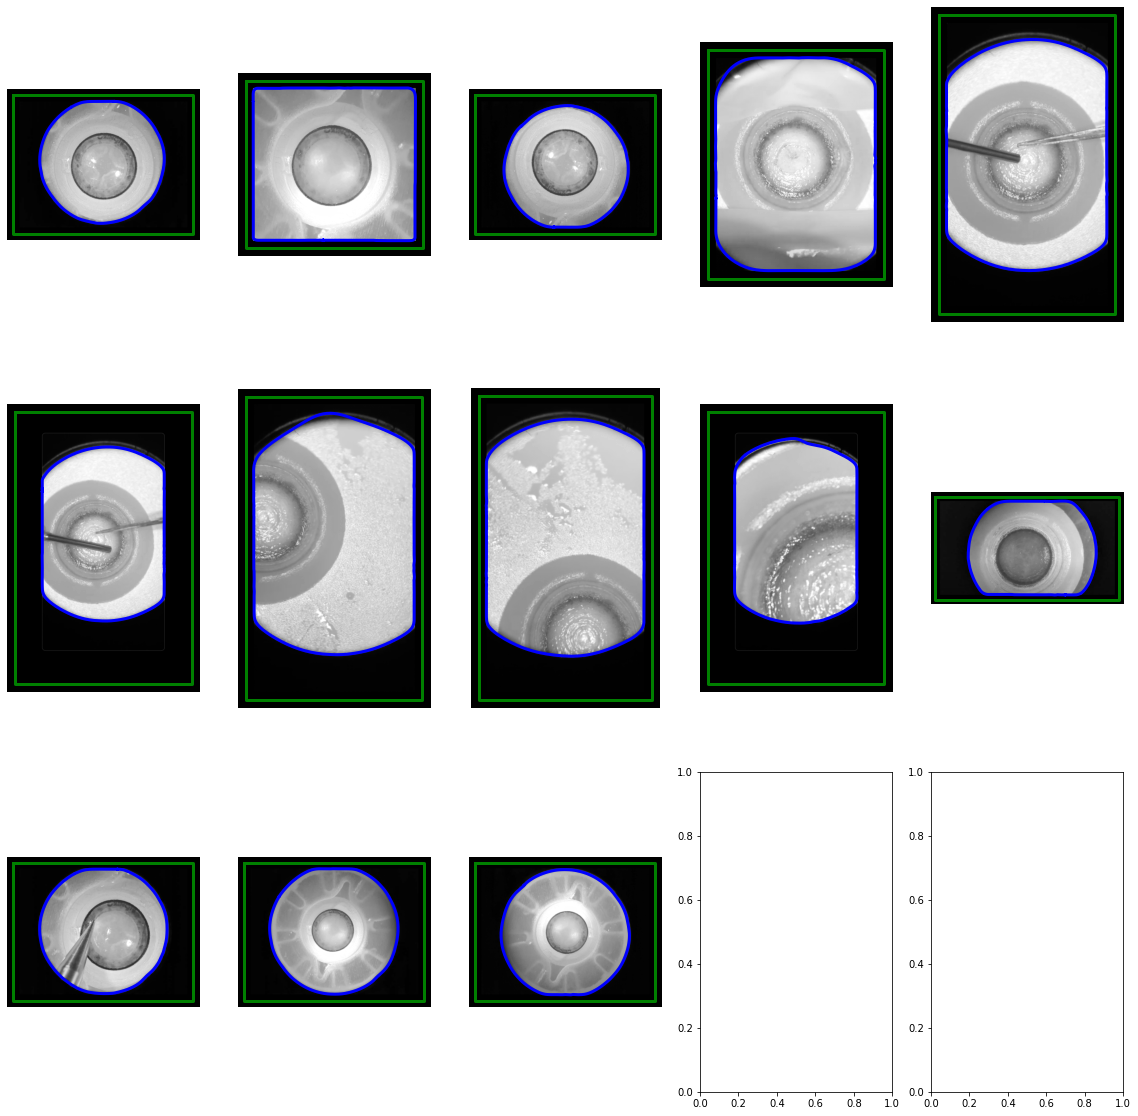

In [7]:
image_paths = [
    'data/artificial/base1.jpeg',
    'data/artificial/base2.jpeg',
    'data/artificial/base3.jpeg',
    'data/artificial/bioniko_rhexis_base2.png',
    'data/artificial/bioniko_rhexis_base3.png',
    'data/artificial/bioniko_rhexis_base4.png',
    'data/artificial/bioniko_rhexis_base5.png',
    'data/artificial/bioniko_rhexis_base6.png',
    'data/artificial/bioniko_rhexis_base7.png',
    'data/artificial/bioniko_rhexis_base8.png',
    'data/artificial/instrument.jpeg',
    'data/artificial/zoomed_out1.jpeg',
    'data/artificial/zoomed_out3.jpeg',
]
columns = 5
processing_width = 480

fig, plots = plt.subplots(
    np.ceil(len(image_paths)/columns).astype(np.int16), columns, figsize=(20, 20))
for i in tqdm(range(len(image_paths))):
    plot = plots[i // columns, i % columns]

    img = cv2.imread(image_paths[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img = img[:, :, 2]
    img = cv2.resize(img, (processing_width, round(
        processing_width*img.shape[0]/img.shape[1])))
    snake, init, img_padded = detect_view_snake(img, return_verbose=True)

    plot.imshow(img_padded, cmap='gray')
    plot.plot(init[:, 1], init[:, 0], '-g', lw=3)
    plot.plot(snake[:, 1], snake[:, 0], '-b', lw=3)
    plot.set_xticks([]), ax.set_yticks([])
    plot.axis([0, img_padded.shape[1], img_padded.shape[0], 0])
    plot.axis('off')

plt.show()

### 6. Performance analysis

In [8]:
print(f'performance at {base_value.shape} resolution')
%timeit detect_view_snake(base_value)

performance at (496, 312) resolution
1.07 s ± 16.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
